**RNN untuk Analisis Sentimen**

**Setup**

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar() # Menonaktifkan tampilan progress bar.

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric): # Mendefinisikan fungsi plot_graphs.
  plt.plot(history.history[metric]) # Membuat garis plot.
  plt.plot(history.history['val_'+metric], '') # Menambahkan garis plot.
  plt.xlabel("Epochs") # Menambahkan label sumbu x.
  plt.ylabel(metric) # Menambahkan label sumbu y.
  plt.legend([metric, 'val_'+metric]) # Menambahkan legend.

**Setup input pipeline**

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True) # Memuat dataset IMDb reviews.
train_dataset, test_dataset = dataset['train'], dataset['test'] # Mengambil dua bagian dari dataset.

train_dataset.element_spec # Memberikan element specification.

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy()) # Mencetak teks.
  print('label: ', label.numpy()) # Mencetak label.

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


**Buat Teks Encoder**

In [5]:
BUFFER_SIZE = 10000 # Menentukan ukuran buffer.
BATCH_SIZE = 64 # Menentukan ukuran batch.

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Mengambil dataset latih.
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Memanggil batch pada dataset uji.

for example, label in train_dataset.take(1): # Memulai loop yang akan mengambil satu batch.
  print('texts: ', example.numpy()[:3]) # Mencetak tiga label pertama.
  print()
  print('labels: ', label.numpy()[:3]) # Mencetak tiga label pertama.

texts:  [b'speaking solely as a movie, i didn\'t really liked it. not because there were no FX or because we had a single cabin as the scenario for the whole film, actually that was what kept me watching it.<br /><br />i didn\'t like it because the acting was shady, his "friends" are all happy and then they\'re mad, but you have no idea why; then they take distinct roles, one is the believer, other is the antagonist, but they never really make the point! also, the lighting was terrible and i\'m just mentioning technical issues.<br /><br />in a few words, i thing the movie could have just had a "ok i\'m outta here!" from some characters. like the lady who doesn\'t want to hear his version of the bible.<br /><br />about the story itself, everyone is free to write about what they want, and the story is proof of some good writing and imagination. i credit the book author for that, hence, my 4/10.<br /><br />so, in the end, hear the man\'s story believe it or not, just don\'t spend the whol

In [6]:
VOCAB_SIZE = 1000 # Membatasi jumlah kata.
encoder = tf.keras.layers.TextVectorization( # Mengonversi teks menjadi representasi numerik.
    max_tokens=VOCAB_SIZE) # Menentukan jumlah kata.
encoder.adapt(train_dataset.map(lambda text, label: text)) 

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20] # Mengambil 20 kata pertama.

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example # Mencetak hasil dari encoding.

array([[  1,   1,  15, ...,   0,   0,   0],
       [131,   1,   1, ...,   0,   0,   0],
       [ 48,   7,   4, ...,   0,   0,   0]])

In [9]:
for n in range(3): # Memulai loop for yang akan berjalan sebanyak tiga kali.
  print("Original: ", example[n].numpy()) # Mencetak teks asli.
  print("Round-trip: ", " ".join(vocab[encoded_example[n]])) # Mencetak teks dari encoding.
  print() # Mencetak baris kosong.

Original:  b'speaking solely as a movie, i didn\'t really liked it. not because there were no FX or because we had a single cabin as the scenario for the whole film, actually that was what kept me watching it.<br /><br />i didn\'t like it because the acting was shady, his "friends" are all happy and then they\'re mad, but you have no idea why; then they take distinct roles, one is the believer, other is the antagonist, but they never really make the point! also, the lighting was terrible and i\'m just mentioning technical issues.<br /><br />in a few words, i thing the movie could have just had a "ok i\'m outta here!" from some characters. like the lady who doesn\'t want to hear his version of the bible.<br /><br />about the story itself, everyone is free to write about what they want, and the story is proof of some good writing and imagination. i credit the book author for that, hence, my 4/10.<br /><br />so, in the end, hear the man\'s story believe it or not, just don\'t spend the wh

**Buat Model**

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding( # Mengubah representasi numerik.
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # Menambahkan lapisan LSTM.
    tf.keras.layers.Dense(64, activation='relu'), # Menambahkan lapisan Dense dengan 64 unit.
    tf.keras.layers.Dense(1) # Menambahkan lapisan Dense dengan 1 unit.
])

In [11]:
print([layer.supports_masking for layer in model.layers]) # Mencetak daftar boolean.

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0]) # Mencetak hasil prediks.

1/1 [==============================] - 2s 2s/step
[-0.01599761]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000 # Teks tambahan untuk pengujian.
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0]) # Mencetak hasil prediksi.

1/1 [==============================] - 0s 212ms/step
[-0.01599762]


In [14]:
# Mengonfigurasi model untuk pelatihan.
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train Model**

In [15]:
# Melakukan proses pelatihan model.
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 347s 871ms/step - loss: 0.6468 - accuracy: 0.5561 - val_loss: 0.5395 - val_accuracy: 0.6615
Epoch 2/10
391/391 [==============================] - 337s 863ms/step - loss: 0.4600 - accuracy: 0.7663 - val_loss: 0.4585 - val_accuracy: 0.8240
Epoch 3/10
391/391 [==============================] - 339s 867ms/step - loss: 0.3905 - accuracy: 0.8299 - val_loss: 0.4430 - val_accuracy: 0.7885
Epoch 4/10
391/391 [==============================] - 337s 862ms/step - loss: 0.3548 - accuracy: 0.8442 - val_loss: 0.3401 - val_accuracy: 0.8453
Epoch 5/10
391/391 [==============================] - 332s 847ms/step - loss: 0.3248 - accuracy: 0.8603 - val_loss: 0.3327 - val_accuracy: 0.8594
Epoch 6/10
391/391 [==============================] - 339s 865ms/step - loss: 0.3149 - accuracy: 0.8636 - val_loss: 0.3236 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 335s 857ms/step - loss: 0.3076 - accuracy: 0.8685 - val_loss: 0.3420 -

In [16]:
# Melakukan evaluasi performa model.
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 83s 210ms/step - loss: 0.3153 - accuracy: 0.8568
Test Loss: 0.31525328755378723
Test Accuracy: 0.8567600250244141


(0.0, 0.664213627576828)

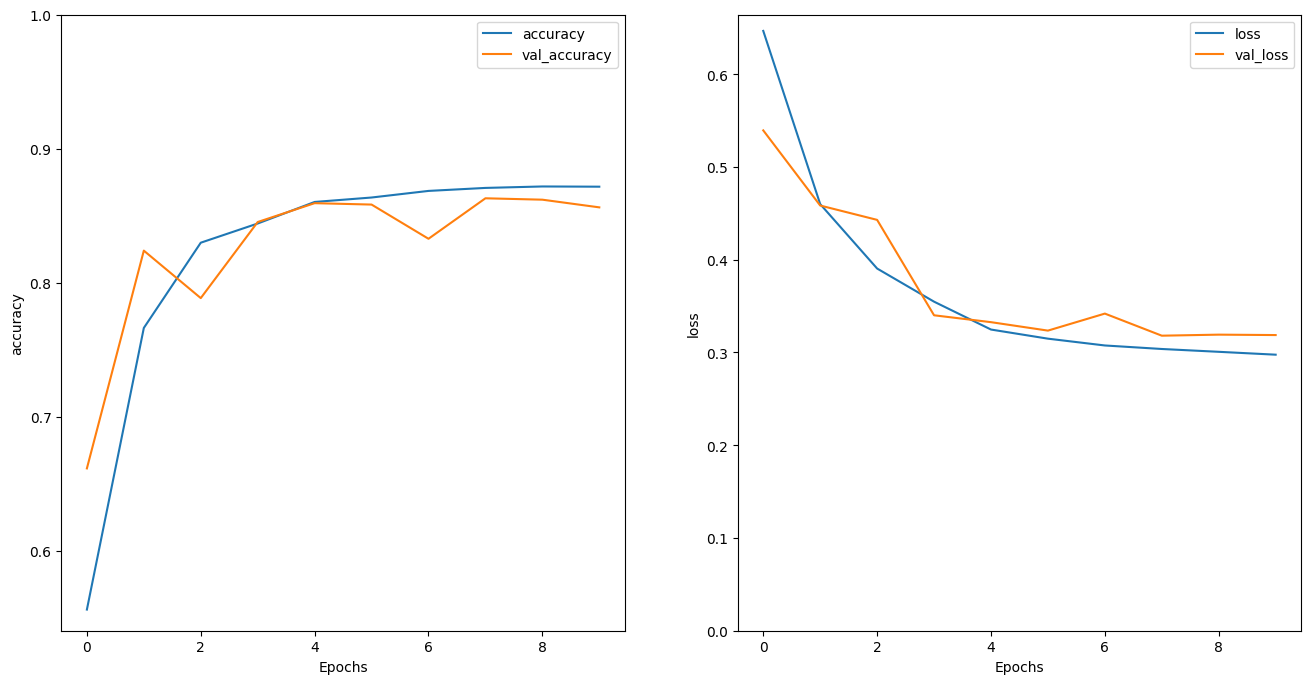

In [17]:
plt.figure(figsize=(16, 8)) # Membuat figure.
plt.subplot(1, 2, 1) # Subplot pertama.
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2) # Subplot kedua.
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.') # Mendefinisikan sebuah variabel sample_text.
predictions = model.predict(np.array([sample_text])) # Melakukan prediksi sentimen.

1/1 [==============================] - 2s 2s/step


**Stack two or more LSTM layers**

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'), # Menambahkan lapisan Dense dengan 64 unit.
    tf.keras.layers.Dropout(0.5), # Menambahkan lapisan dropout.
    tf.keras.layers.Dense(1) # Menambahkan lapisan Dense dengan 1 unit.
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # Model akan mengeluarkan logits.
              optimizer=tf.keras.optimizers.Adam(1e-4), # Menentukan optimizer.
              metrics=['accuracy']) # Mengevaluasi performa model.

In [23]:
# Melakukan proses pelatihan model.
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 688s 2s/step - loss: 0.6371 - accuracy: 0.5726 - val_loss: 0.4568 - val_accuracy: 0.7786
Epoch 2/10
391/391 [==============================] - 651s 2s/step - loss: 0.3994 - accuracy: 0.8252 - val_loss: 0.3609 - val_accuracy: 0.8495
Epoch 3/10
391/391 [==============================] - 678s 2s/step - loss: 0.3399 - accuracy: 0.8537 - val_loss: 0.3496 - val_accuracy: 0.8417
Epoch 4/10
391/391 [==============================] - 669s 2s/step - loss: 0.3200 - accuracy: 0.8633 - val_loss: 0.3242 - val_accuracy: 0.8583
Epoch 5/10
391/391 [==============================] - 664s 2s/step - loss: 0.3123 - accuracy: 0.8656 - val_loss: 0.3383 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 663s 2s/step - loss: 0.3082 - accuracy: 0.8677 - val_loss: 0.3250 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 651s 2s/step - loss: 0.3054 - accuracy: 0.8681 - val_loss: 0.3304 - val_accuracy: 0.8583

In [24]:
test_loss, test_acc = model.evaluate(test_dataset) # Melakukan evaluasi.

print('Test Loss:', test_loss) # Mencetak nilai loss.
print('Test Accuracy:', test_acc) # Mencetak nilai akurasi.

391/391 [==============================] - 149s 382ms/step - loss: 0.3194 - accuracy: 0.8648
Test Loss: 0.3193904757499695
Test Accuracy: 0.8647599816322327


In [25]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.') # Mendefinisikan sebuah variabel sample_text.
predictions = model.predict(np.array([sample_text])) # Melakukan prediksi sentimen.
print(predictions) # Cetak prediksi.

1/1 [==============================] - 4s 4s/step
[[-2.0348482]]


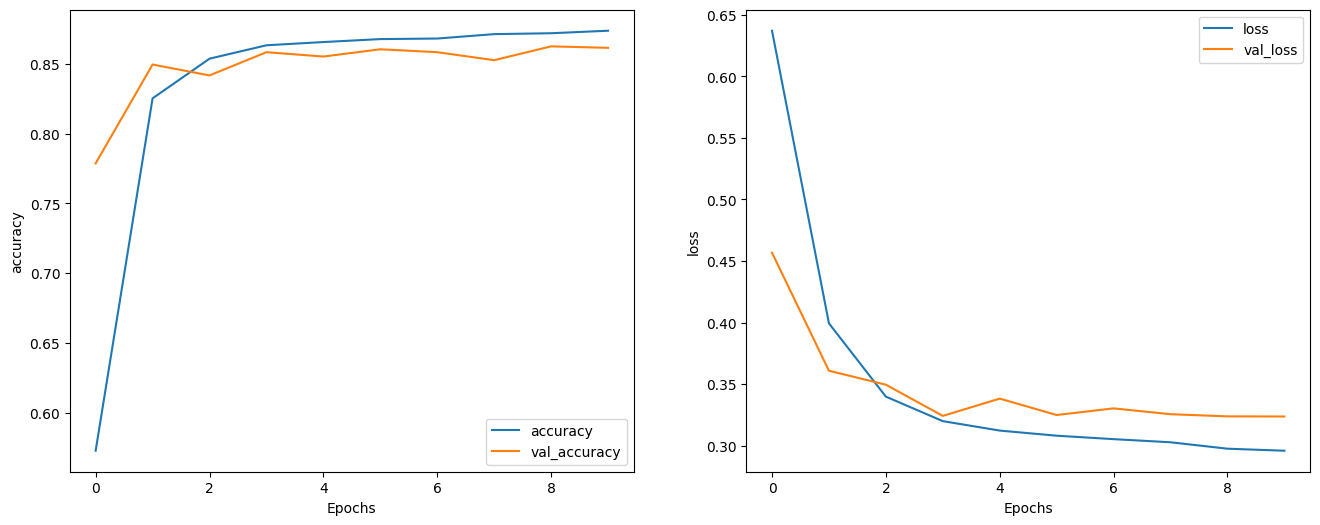

In [26]:
plt.figure(figsize=(16, 6)) # Membuat figure.
plt.subplot(1, 2, 1) # Membagi gambar menjadi dua subplot.
plot_graphs(history, 'accuracy') # Fungsi plot_graphs untuk memplot grafik akurasi.
plt.subplot(1, 2, 2) # Subplot kedua.
plot_graphs(history, 'loss') # Fungsi plot_graphs untuk memplot grafik loss.